In [17]:
import numpy as np 
import pandas as pd
import scipy as scipy
import datetime as dt
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Reading Data
train_df =  pd.read_csv('./input/train.csv', nrows = 1000000)
#Drop rows with null values
train_df = train_df.dropna(how = 'any', axis = 'rows')

def clean_df(df):
    return df[(df.fare_amount > 0)  & (df.fare_amount <= 500) & 
          # (df.passenger_count >= 0) & (df.passenger_count <= 8)  &
            ((df.pickup_longitude != 0) & (df.pickup_latitude != 0) & (df.dropoff_longitude != 0) & (df.dropoff_latitude != 0) ) 
             ]

train_df = clean_df(train_df)

In [9]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [10]:
test_df =  pd.read_csv('./input/test.csv')
print(test_df.head())

                           key          pickup_datetime  pickup_longitude  \
0  2015-01-27 13:08:24.0000002  2015-01-27 13:08:24 UTC        -73.973320   
1  2015-01-27 13:08:24.0000003  2015-01-27 13:08:24 UTC        -73.986862   
2  2011-10-08 11:53:44.0000002  2011-10-08 11:53:44 UTC        -73.982524   
3  2012-12-01 21:12:12.0000002  2012-12-01 21:12:12 UTC        -73.981160   
4  2012-12-01 21:12:12.0000003  2012-12-01 21:12:12 UTC        -73.966046   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0        40.763805         -73.981430         40.743835                1  
1        40.719383         -73.998886         40.739201                1  
2        40.751260         -73.979654         40.746139                1  
3        40.767807         -73.990448         40.751635                1  
4        40.789775         -73.988565         40.744427                1  


In [11]:
print("Range of Pickup Latitude is ", (min(train_df['pickup_latitude']),max(train_df['pickup_latitude'])))

Range of Pickup Latitude is  (-880.6274279999999, 2621.62843)


In [12]:
print("Range of Dropoff Latitude is ", (min(train_df['dropoff_latitude']),max(train_df['dropoff_longitude'])))

Range of Dropoff Latitude is  (-3114.3385670000002, 45.581619)


The data is for Taxi Rides in Newyork, whose center lat, lng is at ((40,-74).The range of dropoff and pickup latitudes indicates lot of outlier locations in the train data.

In [13]:
print("Longitude Boundary in test data")
min(test_df.pickup_longitude.min(), test_df.dropoff_longitude.min()),max(test_df.pickup_longitude.max(), test_df.dropoff_longitude.max())

Longitude Boundary in test data


(-74.263242, -72.986532)

In [14]:
print("Latitude Boundary in test_df data")
min(test_df.pickup_latitude.min(), test_df.pickup_latitude.min()),max(test_df.pickup_latitude.max(), test_df.pickup_latitude.max())

Latitude Boundary in test_df data


(40.573143, 41.709555)

In [15]:
boundary={'min_lng':-74.263242,
              'min_lat':40.573143,
              'max_lng':-72.986532, 
              'max_lat':41.709555}

In [16]:
train_df.loc[~((train_df.pickup_longitude >= boundary['min_lng'] ) & (train_df.pickup_longitude <= boundary['max_lng']) &
            (train_df.pickup_latitude >= boundary['min_lat']) & (train_df.pickup_latitude <= boundary['max_lat']) &
            (train_df.dropoff_longitude >= boundary['min_lng']) & (train_df.dropoff_longitude <= boundary['max_lng']) &
            (train_df.dropoff_latitude >=boundary['min_lat']) & (train_df.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=1
train_df.loc[((train_df.pickup_longitude >= boundary['min_lng'] ) & (train_df.pickup_longitude <= boundary['max_lng']) &
            (train_df.pickup_latitude >= boundary['min_lat']) & (train_df.pickup_latitude <= boundary['max_lat']) &
            (train_df.dropoff_longitude >= boundary['min_lng']) & (train_df.dropoff_longitude <= boundary['max_lng']) &
            (train_df.dropoff_latitude >=boundary['min_lat']) & (train_df.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=0

print("Outlier vs Non Outlier Counts")
print(train_df['is_outlier_loc'].value_counts())

# Let us drop rows, where location is outlier
train_df=train_df.loc[train_df['is_outlier_loc']==0]
train_df.drop(['is_outlier_loc'],axis=1,inplace=True)

Outlier vs Non Outlier Counts
0.0    978775
1.0      1492
Name: is_outlier_loc, dtype: int64


### Heatmap of Pickups and Dropoffs within NYC

(-74.03, -73.75)

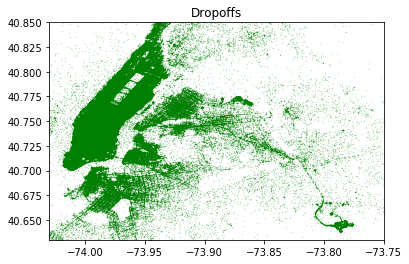

In [19]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.scatter(train_df.dropoff_longitude, train_df.dropoff_latitude,
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)


(-74.03, -73.75)

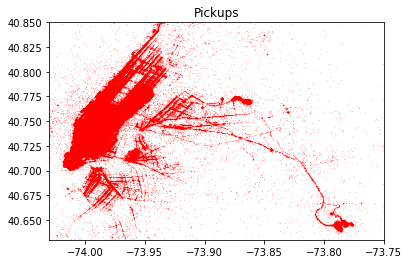

In [20]:
plt.scatter(train_df.pickup_longitude, train_df.pickup_latitude,
                color='red', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

From the scatter plot, we can observe the high density of pickups and dropoffs from and to JFK and La Guardia Airport.

In [21]:
jfk={'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659}
jfk_center=[40.6437,-73.7900]
# Get all pickups to jfk
jfk_data=train_df.loc[(train_df.pickup_latitude>=jfk['min_lat']) & (train_df.pickup_latitude<=jfk['max_lat'])]
jfk_data=jfk_data.loc[(train_df.pickup_longitude>=jfk['min_lng']) & (train_df.pickup_longitude<=jfk['max_lng'])]

print("Number of Trips with Pickups from jfk",jfk_data.shape[0])

jfk_dropoff=train_df.loc[(train_df.dropoff_latitude>=jfk['min_lat']) & (train_df.dropoff_latitude<=jfk['max_lat'])]
jfk_dropoff=jfk_dropoff.loc[(train_df.dropoff_longitude>=jfk['min_lng']) & (train_df.dropoff_longitude<=jfk['max_lng'])]

print("Number of Trips with Dropoffs to jfk",jfk_dropoff.shape[0])


Number of Trips with Pickups from jfk 14961
Number of Trips with Dropoffs to jfk 7686


Text(0.5, 1.0, 'Fare Amount Distribution')

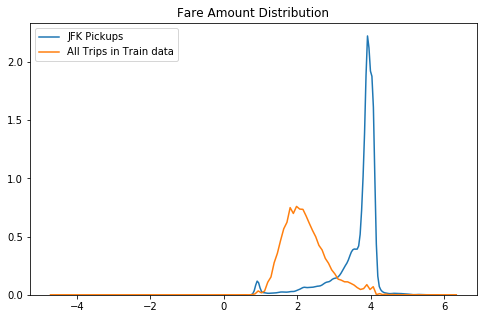

In [23]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(jfk_data['fare_amount'].values),label='JFK Pickups')
#sns.kdeplot(np.log(jfk_dropoff['fare_amount'].values),label='jfk Dropoff')
sns.kdeplot(np.log(train_df['fare_amount'].values),label='All Trips in Train data')
plt.title("Fare Amount Distribution")

Text(0.5, 1.0, 'Dropoffs vs Fare Amount')

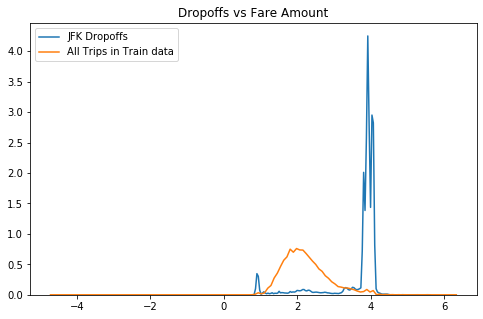

In [24]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(jfk_dropoff['fare_amount'].values),label='JFK Dropoffs')
sns.kdeplot(np.log(train_df['fare_amount'].values),label='All Trips in Train data')
plt.title("Dropoffs vs Fare Amount")

Distribution of fare amount for both pickup and dropoff to JFK is similar. Obviously, trips starting and ending with jfk are significantly more expensive, so we believe that landmarks will obviously affect the fare of a ride.

In [25]:
# To Compute Haversine distance
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R_earth * c

def sphere_dist_bear(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    #Compute initial bearing
    a = np.arctan2(np.sin(dlon) * np.cos(dropoff_lat),np.cos(pickup_lat) * np.sin(dropoff_lat)  - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(dlon))
    return a   

def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    SOL: Statue of Liberty 
    NYC: Newyork Central
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    sol_coord = (40.6892,-74.0445) # Statue of Liberty
    nyc_coord = (40.7141667,-74.0063889) 
    
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon)
    pickup_sol = sphere_dist(pickup_lat, pickup_lon, sol_coord[0], sol_coord[1]) 
    dropoff_sol = sphere_dist(sol_coord[0], sol_coord[1], dropoff_lat, dropoff_lon)
    pickup_nyc = sphere_dist(pickup_lat, pickup_lon, nyc_coord[0], nyc_coord[1]) 
    dropoff_nyc = sphere_dist(nyc_coord[0], nyc_coord[1], dropoff_lat, dropoff_lon)
    
    
    
    dataset['jfk_dist'] = pickup_jfk + dropoff_jfk
    dataset['ewr_dist'] = pickup_ewr + dropoff_ewr
    dataset['lga_dist'] = pickup_lga + dropoff_lga
    dataset['sol_dist'] = pickup_sol + dropoff_sol
    dataset['nyc_dist'] = pickup_nyc + dropoff_nyc
    
    return dataset
    
def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year
    
    return dataset

In [26]:
train_df = add_datetime_info(train_df)
train_df = add_airport_dist(train_df)
train_df['distance'] = sphere_dist(train_df['pickup_latitude'], train_df['pickup_longitude'], 
                                   train_df['dropoff_latitude'] , train_df['dropoff_longitude']) 

train_df['bearing'] = sphere_dist_bear(train_df['pickup_latitude'], train_df['pickup_longitude'], 
                                   train_df['dropoff_latitude'] , train_df['dropoff_longitude'])                                    
train_df['pickup_latitude'] = np.radians(train_df['pickup_latitude'])
train_df['pickup_longitude'] = np.radians(train_df['pickup_longitude'])
train_df['dropoff_latitude'] = np.radians(train_df['dropoff_latitude'])
train_df['dropoff_longitude'] = np.radians(train_df['dropoff_longitude'])



/Users/kenxu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Distribution of Trip Distance (log scale)')

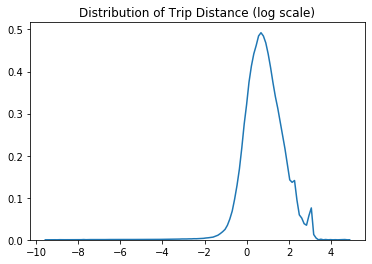

In [27]:
sns.kdeplot(np.log(train_df['distance'].values)).set_title("Distribution of Trip Distance (log scale)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount')

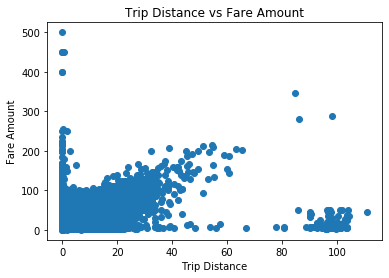

In [29]:
plt.scatter(x=train_df['distance'],y=train_df['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")

In [30]:

train_df.drop(columns=['key', 'pickup_datetime'], inplace=True)

y = train_df['fare_amount']
train_df = train_df.drop(columns=['fare_amount'])


print(train_df.head())

x_train,x_test,y_train,y_test = train_test_split(train_df,y,random_state=123,test_size=0.10)

# del train_df
# del y
gc.collect()

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0         -1.288826         0.710721          -1.288779          0.710563   
1         -1.291824         0.710546          -1.291182          0.711780   
2         -1.291242         0.711418          -1.291391          0.711231   
3         -1.291319         0.710927          -1.291396          0.711363   
4         -1.290987         0.711536          -1.290787          0.711811   

   passenger_count  hour  day  month  weekday  year   jfk_dist   ewr_dist  \
0                1    17   15      6        0  2009  20.265840  55.176046   
1                1    16    5      1        1  2010  44.667679  31.832358   
2                2     0   18      8        3  2011  43.597686  33.712082   
3                1     4   21      4        5  2012  42.642965  32.556289   
4                1     7    9      3        1  2010  43.329953  39.406828   

    lga_dist   sol_dist   nyc_dist  distance   bearing  
0  14.342611  34.

4871

In [31]:

test_df = add_datetime_info(test_df)
test_df = add_airport_dist(test_df)
test_df['distance'] = sphere_dist(test_df['pickup_latitude'], test_df['pickup_longitude'], 
                                   test_df['dropoff_latitude'] , test_df['dropoff_longitude'])

test_df['bearing'] = sphere_dist_bear(test_df['pickup_latitude'], test_df['pickup_longitude'], 
                                    test_df['dropoff_latitude'] , test_df['dropoff_longitude'])  
test_df['pickup_latitude'] = np.radians(test_df['pickup_latitude'])
test_df['pickup_longitude'] = np.radians(test_df['pickup_longitude'])
test_df['dropoff_latitude'] = np.radians(test_df['dropoff_latitude'])
test_df['dropoff_longitude'] = np.radians(test_df['dropoff_longitude'])
                                                                    


test_key = test_df['key']
test_df = test_df.drop(columns=['key', 'pickup_datetime'])

## LightGBM

In [32]:
seed = 0

In [33]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':seed,
        'num_rounds':50000
    }
    
train_set = lgbm.Dataset(x_train, y_train, silent=False,categorical_feature=['year','month','day','weekday'])
valid_set = lgbm.Dataset(x_test, y_test, silent=False,categorical_feature=['year','month','day','weekday'])
model = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)
# del x_train
# del y_train
# del x_test
# del y_test
                        


#Predict from test set
prediction = model.predict(test_df, num_iteration = model.best_iteration)      
submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction
})

submission.to_csv('taxi_fare_submission_LGBM.csv',index=False)

/Users/kenxu/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/kenxu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 3.48728
[1000]	valid_0's rmse: 3.44891
[1500]	valid_0's rmse: 3.43355
[2000]	valid_0's rmse: 3.42795
[2500]	valid_0's rmse: 3.42409
[3000]	valid_0's rmse: 3.41928
[3500]	valid_0's rmse: 3.4183
[4000]	valid_0's rmse: 3.41901
Early stopping, best iteration is:
[3644]	valid_0's rmse: 3.41776


In [93]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

AttributeError: 'Booster' object has no attribute 'feature_importances_'

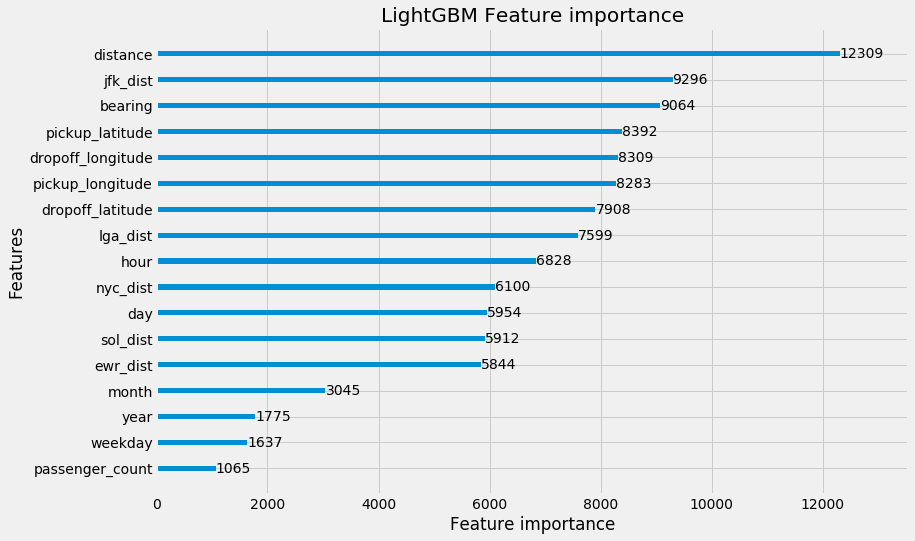

In [113]:
lgbm.plot_importance(model, title='LightGBM Feature importance', xlabel='Feature importance', ylabel='Features'
                     ,figsize=(12, 8), importance_type='split')

In [34]:
from sklearn import metrics
y_pred_LGB = model.predict(x_test, num_iteration = model.best_iteration)      
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_LGB))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_LGB))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_LGB)))

Mean Absolute Error: 1.5536498502362515
Mean Squared Error: 11.681101253185329
Root Mean Squared Error: 3.4177626092497015


In [6]:
x_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
327119,-1.291427,0.711336,-1.291223,0.711719,1,23,11,12,2,2013,45.283463,34.827027,19.603483,19.893675,12.287959,2.631879,-0.383970
464486,-1.291487,0.710707,-1.290762,0.711549,5,0,3,4,4,2009,41.108927,34.696223,19.235185,16.932663,8.519185,6.406238,-0.577411
139048,-1.291211,0.711717,-1.291211,0.711716,1,16,21,4,1,2015,45.939622,36.943560,18.241799,22.535858,14.904828,0.001064,-2.493473
408792,-1.291090,0.711450,-1.291438,0.711159,1,18,31,8,2,2011,43.083783,34.072465,19.462568,17.792682,9.818764,2.499382,2.404260
543202,-1.289321,0.711641,-1.290923,0.711477,1,13,14,4,5,2012,37.815521,45.519324,8.215975,28.049299,19.721713,7.801934,1.704504


## RandomForest

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 100).astype(int),
    'max_depth': [None] + list(np.linspace(5, 30).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestRegressor(random_state = seed)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'neg_mean_absolute_error', cv = 3, 
                        n_iter = 100, verbose = 1, random_state=seed)

In [12]:
rs.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 189.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 294.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [14]:
model1 = rs.best_estimator_
print(f'The best parameters were {rs.best_params_} with a negative mae of {rs.best_score_}')

The best parameters were {'n_estimators': 35, 'min_samples_split': 10, 'max_leaf_nodes': 48, 'max_features': 0.7999999999999999, 'max_depth': 8, 'bootstrap': True} with a negative mae of -2.1224018354088674


In [108]:
filename3 = 'RF_best_para.sav'
model1 = pickle.load(open(filename3, 'rb')).best_estimator_

In [109]:
model1.n_jobs = -1
model1.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features=0.7999999999999999, max_leaf_nodes=48,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [118]:
from sklearn import metrics
y_pred_rf = model1.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))

Mean Absolute Error: 2.1049896068953986
Mean Squared Error: 15.79861440889733
Root Mean Squared Error: 3.9747470874129


In [119]:
prediction_rf = model1.predict(test_df)      
submission_rf = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction_rf
})

submission_rf.to_csv('taxi_fare_submission_RF.csv',index=False)

Text(0.5, 0, 'Relative Importance')

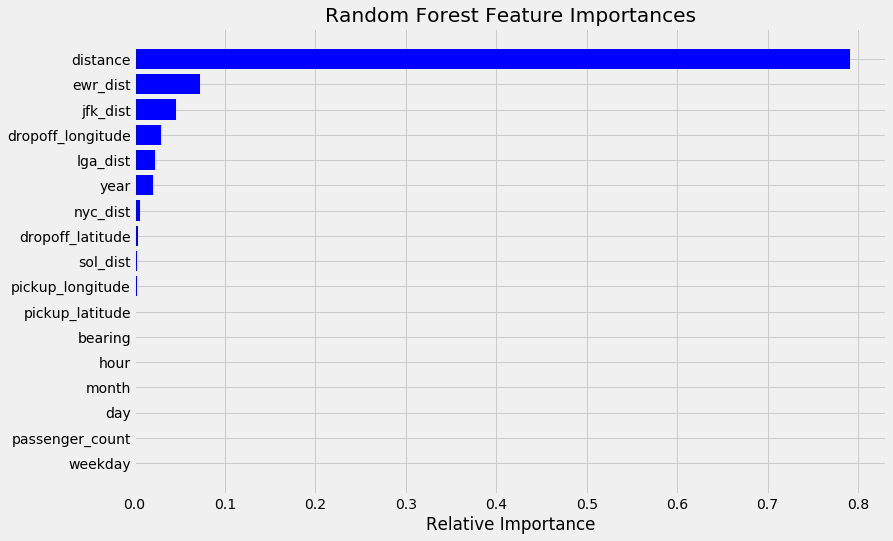

In [112]:
plt.style.use('fivethirtyeight')
features = x_train.columns[:]
importances_rf = model1.feature_importances_
indices = np.argsort(importances_rf)
plt.figure(figsize=(12, 8))
plt.title('Random Forest Feature Importances')
plt.barh(range(len(indices)), importances_rf[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [67]:
indices

array([ 8,  5,  6,  7,  4, 16,  1, 13,  0, 14,  3,  9, 12,  2, 10, 11, 15])

## XGBoost

In [104]:
import xgboost as xgb

def XGBoost(X_train,X_test,y_train,y_test,num_rounds=300):
    dtrain = xgb.DMatrix(x_train,label=y_train)
    dtest = xgb.DMatrix(x_test,label=y_test)

    return xgb.train(params={'objective':'reg:linear','eval_metric':'rmse'}
                    ,dtrain=dtrain,num_boost_round=num_rounds, 
                    early_stopping_rounds=20,evals=[(dtest,'test')],)

In [105]:
xgbm = XGBoost(x_train,x_test,y_train,y_test)
xgbm_pred = xgbm.predict(xgb.DMatrix(test_df), ntree_limit = xgbm.best_ntree_limit)

[14:44:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:10.5553
Will train until test-rmse hasn't improved in 20 rounds.
[1]	test-rmse:7.94667
[2]	test-rmse:6.26263
[3]	test-rmse:5.21508
[4]	test-rmse:4.5721
[5]	test-rmse:4.20335
[6]	test-rmse:4.00648
[7]	test-rmse:3.87684
[8]	test-rmse:3.81208
[9]	test-rmse:3.76678
[10]	test-rmse:3.73635
[11]	test-rmse:3.7051
[12]	test-rmse:3.68821
[13]	test-rmse:3.67964
[14]	test-rmse:3.67129
[15]	test-rmse:3.66677
[16]	test-rmse:3.65889
[17]	test-rmse:3.64868
[18]	test-rmse:3.6452
[19]	test-rmse:3.63954
[20]	test-rmse:3.63103
[21]	test-rmse:3.6267
[22]	test-rmse:3.61856
[23]	test-rmse:3.61891
[24]	test-rmse:3.61629
[25]	test-rmse:3.61544
[26]	test-rmse:3.6099
[27]	test-rmse:3.60613
[28]	test-rmse:3.6069
[29]	test-rmse:3.60849
[30]	test-rmse:3.60749
[31]	test-rmse:3.60488
[32]	test-rmse:3.60264
[33]	test-rmse:3.602
[34]	test-rmse:3.60266
[35]	test-rmse:3.603
[36]	test-rmse:3.59

In [120]:
submission_XGB = pd.DataFrame({
        "key": test_key,
        "fare_amount": xgbm_pred
})

submission_rf.to_csv('taxi_fare_submission_XGB.csv',index=False)

In [52]:
y_pred_xgb = xgbm.predict(xgb.DMatrix(x_test), ntree_limit = xgbm.best_ntree_limit)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_xgb))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_xgb))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb)))

Mean Absolute Error: 1.6521490913140362
Mean Squared Error: 14.091715304249988
Root Mean Squared Error: 3.7538933528071876


<Figure size 432x288 with 0 Axes>

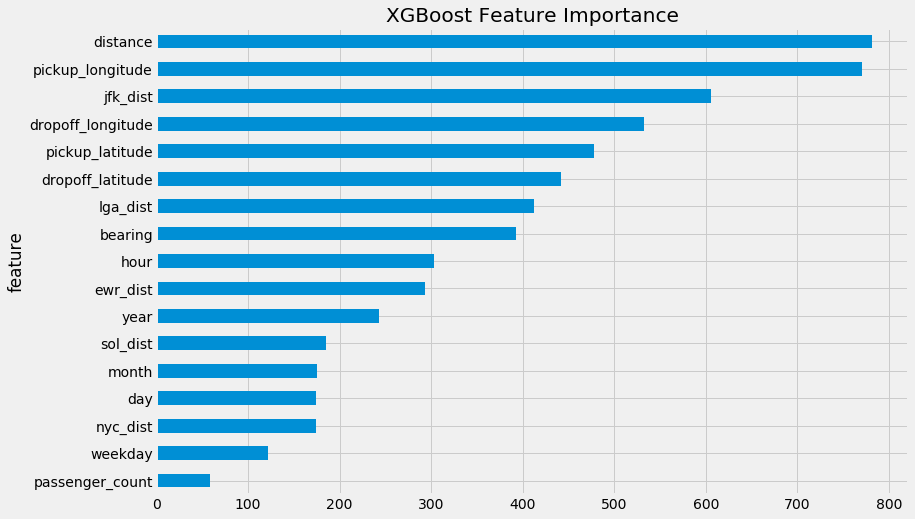

In [111]:
import operator
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
importance_xgb = xgbm.get_score()
importance_xgb = sorted(importance_xgb.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance_xgb, columns=['feature', 'score'])
plt.figure()

df.plot(kind='barh', x='feature', y='score', legend=False, figsize=(12, 8))
plt.title("XGBoost Feature Importance")
plt.show()

## DNN

In [35]:
# Model parameters
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.001

In [43]:
from sklearn import preprocessing
# Scale data
# Note: im doing this here with sklearn scaler but, on the Coursera code the scaling is done with Dataflow and Tensorflow
scaler = preprocessing.MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
test_scaled = scaler.transform(test_df)

In [77]:
import tensorflow as tf
from tensorflow.keras.layers import *
model_nn = tf.keras.Sequential()
model_nn.add(Dense(256, activation='relu', input_dim=x_train_scaled.shape[1], activity_regularizer=tf.keras.regularizers.l1(0.01)))
model_nn.add(BatchNormalization())
model_nn.add(Dense(128, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(64, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(32, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(8, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(1))

adam = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_nn.compile(loss='mse', optimizer=adam, metrics=['mae'])

In [78]:
model_nn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 256)               4608      
_________________________________________________________________
batch_normalization_30 (Batc (None, 256)               1024      
_________________________________________________________________
dense_38 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_31 (Batc (None, 128)               512       
_________________________________________________________________
dense_39 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_32 (Batc (None, 64)                256       
_________________________________________________________________
dense_40 (Dense)             (None, 32)               

In [79]:
filepath = "saved-model-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(filepath, monitor='val_mae', verbose=1, save_best_only=True, mode='auto', save_freq='epoch')
callbacks_list = [checkpoint]
history = model_nn.fit(x=x_train_scaled, y=y_train.values, batch_size=BATCH_SIZE, epochs=50, 
                    verbose=1, validation_data=(x_test_scaled, y_test.values), callbacks=callbacks_list,
                    shuffle=True)


Train on 880897 samples, validate on 97878 samples
Epoch 1/50
880640/880897 [============================>.] - ETA: 0s - loss: 39.9607 - mae: 3.5661
Epoch 00001: val_mae improved from inf to 2.17294, saving model to saved-model-01-18.59.hdf5
880897/880897 [==============================] - 85s 96us/sample - loss: 39.9516 - mae: 3.5656 - val_loss: 18.5928 - val_mae: 2.1729
Epoch 2/50
880896/880897 [============================>.] - ETA: 0s - loss: 19.2504 - mae: 2.0861
Epoch 00002: val_mae did not improve from 2.17294
880897/880897 [==============================] - 81s 92us/sample - loss: 19.2503 - mae: 2.0861 - val_loss: 20.6522 - val_mae: 2.8405
Epoch 3/50
880640/880897 [============================>.] - ETA: 0s - loss: 18.2553 - mae: 2.0215
Epoch 00003: val_mae improved from 2.17294 to 2.00189, saving model to saved-model-03-15.35.hdf5
880897/880897 [==============================] - 81s 92us/sample - loss: 18.2586 - mae: 2.0216 - val_loss: 15.3468 - val_mae: 2.0019
Epoch 4/50
88064

Epoch 29/50
880640/880897 [============================>.] - ETA: 0s - loss: 15.1244 - mae: 1.7949
Epoch 00029: val_mae did not improve from 1.72440
880897/880897 [==============================] - 79s 90us/sample - loss: 15.1266 - mae: 1.7949 - val_loss: 15.3920 - val_mae: 1.7559
Epoch 30/50
880640/880897 [============================>.] - ETA: 0s - loss: 15.0154 - mae: 1.7992
Epoch 00030: val_mae did not improve from 1.72440
880897/880897 [==============================] - 79s 90us/sample - loss: 15.0175 - mae: 1.7992 - val_loss: 16.0186 - val_mae: 1.9577
Epoch 31/50
880896/880897 [============================>.] - ETA: 0s - loss: 14.9854 - mae: 1.7961
Epoch 00031: val_mae did not improve from 1.72440
880897/880897 [==============================] - 86s 98us/sample - loss: 14.9854 - mae: 1.7961 - val_loss: 18.9300 - val_mae: 1.9473
Epoch 32/50
880896/880897 [============================>.] - ETA: 0s - loss: 14.8977 - mae: 1.7906
Epoch 00032: val_mae did not improve from 1.72440
88089

In [121]:
model_nn.load_weights('saved-model-34-15.95.hdf5')  


In [122]:
prediction_nn = model_nn.predict(test_scaled).reshape(9914)   

In [123]:
submission_nn = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction_nn
})

submission_nn.to_csv('taxi_fare_submission_NN.csv',index=False)

### save models

In [90]:
import pickle

In [44]:


filename1 = 'finalized_LGB_model.sav'
pickle.dump(model, open(filename1, 'wb'))
filename2 = 'finalized_RF_model.sav'
pickle.dump(model1, open(filename2, 'wb'))

In [46]:
filename3 = 'RF_best_para.sav'
pickle.dump(rs, open(filename3, 'wb'))


In [47]:
loaded_rs = pickle.load(open(filename3, 'rb'))
print(f'The best parameters were {loaded_rs.best_params_} with a negative mae of {loaded_rs.best_score_}')

The best parameters were {'n_estimators': 35, 'min_samples_split': 10, 'max_leaf_nodes': 48, 'max_features': 0.7999999999999999, 'max_depth': 8, 'bootstrap': True} with a negative mae of -2.1224018354088674


In [53]:
filename4 = 'finalized_XGB_model.sav'
pickle.dump(xgbm, open(filename4, 'wb'))